<a href="https://colab.research.google.com/github/elm19/GoldSpot-Predictor/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf


data charge

In [ ]:
price_gold = pd.read_csv('https://raw.githubusercontent.com/elm19/GoldSpot-Predictor/refs/heads/djeri/data/processed-data/price-gold.csv')
price_gold['Date'] = pd.to_datetime(price_gold['Date'])  # colonne date
price_gold.set_index('Date', inplace=True)
price_gold.head()


,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2015-01-02,1186.2,1184.0,1194.9,1167.3,120680.0,0.18%
2015-01-05,1204.0,1187.8,1207.5,1177.8,149110.0,1.50%
2015-01-06,1219.4,1204.0,1223.3,1201.6,190360.0,1.28%
2015-01-07,1210.7,1219.0,1219.4,1209.1,117090.0,-0.71%
2015-01-08,1208.5,1211.0,1216.8,1204.2,122490.0,-0.18%


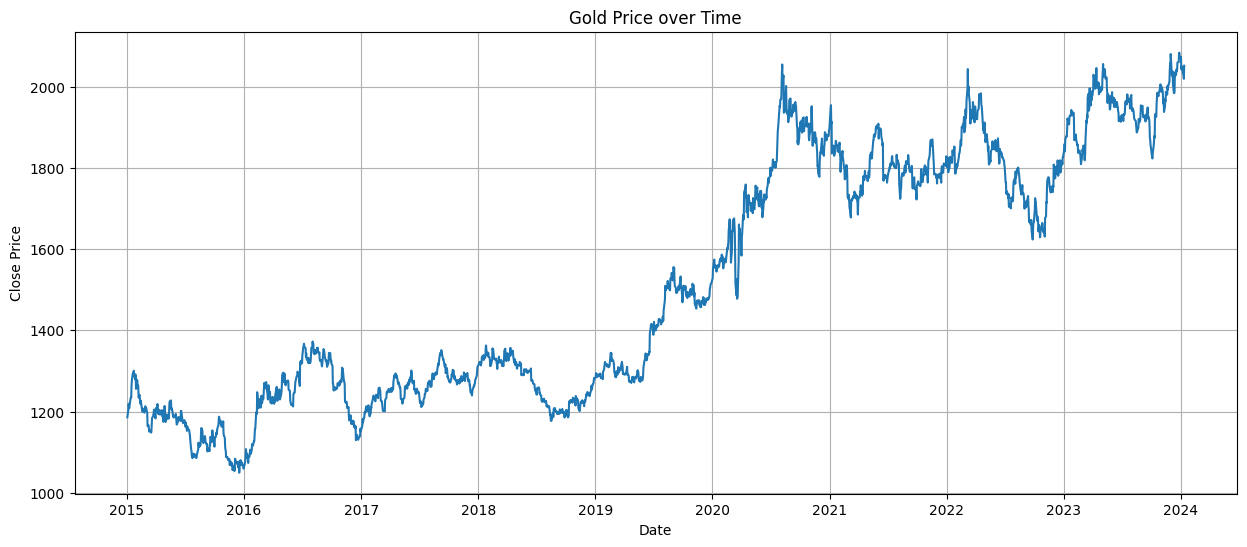

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(price_gold.index, price_gold['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Gold Price over Time')
plt.grid(True)
plt.show()

In [ ]:
data = price_gold[['Open', 'Close', 'High', 'Low', 'Vol.']].copy()
data = data.dropna()


Scaling data

In [ ]:
scalerX = MinMaxScaler()
scaled_X = scalerX.fit_transform(data.iloc[:,1:].values)

scalery = MinMaxScaler()
scaled_y = scalery.fit_transform(data.iloc[:,0].values.reshape(-1, 1))

parametre fixing

In [ ]:
lookback_period = 10
horizon = 6



In [ ]:
def create_sequences(X,y , lookback , horizon ):
  Xs,ys = [] , []
  for i in range(lookback , len(data)-horizon ):
    Xs.append(X[i-lookback:i])
    ys.append(y[i:i+horizon].flatten()) #predict the 'Close' price

  return np.array(Xs), np.array(ys)

X, y = create_sequences(data.iloc[:, 1:].values, data.iloc[:, 0].values, lookback_period, horizon)
X_scaled, y_scaled = create_sequences(scaled_X , scaled_y, lookback_period,horizon)


In [ ]:
data.shape

(2316, 5)

In [ ]:
X.shape

(2300, 10, 4)

split data

In [ ]:
percent= 0.2
train_size = int(len(data) * 0.6)
test_size = int(len(data) * 0.2)
valid_size = int(len(data) * 0.2)

In [ ]:
X_train, X_vald ,  X_test  = X_scaled[:train_size , :], X_scaled[train_size:(train_size+valid_size) , :] , X_scaled[(train_size+valid_size):]
y_train, y_vald ,  y_test  = y_scaled[:train_size , :], y_scaled[train_size:(train_size+valid_size) , :] , y_scaled[(train_size+valid_size):]


reshape necessaire

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1389, 10, 4)
Shape of X_test: (448, 10, 4)
Shape of y_train: (1389, 6)
Shape of y_test: (448, 6)


In [ ]:
try:
    layer = tf.keras.layers.LSTM(units=50, return_sequences=True)
    print("tf.keras.models!")
except AttributeError as e:
    print(f"Error: {e}")

tf.keras.models!


#Model

function necessary

In [ ]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, epochs=100, batch_size=32,verbose=2):
    # Reshape selon le modèle
    if model_name in ["RNN simple", "LSTM", "Bidirectionnel LSTM", "GRU"]:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    elif model_name == "CNN 1D":
        X_train = X_train[:, :, 0].reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val[:, :, 0].reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test[:, :, 0].reshape(X_test.shape[0], X_test.shape[1], 1)
    elif model_name == "MLP":
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_val = X_val.reshape((X_val.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))

    # trainning
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=verbose)

    # evaluation
    loss = model.evaluate(X_test, y_test)
    # model.save(f"{model_name}.h5")
    # print(f"Modèle '{model_name}' sauvegardé avec un test loss de {loss:.4f}")
    print(model.summary())

    return history, loss


In [ ]:
def create_mlp_model(window_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(50, activation='relu', input_shape=(window_size,)),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(6)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_rnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(6)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_lstm_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(6)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_bilstm_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=input_shape),
        tf.keras.layers.Dense(6)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_conv_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(6)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_gru_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(50, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(6)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model






Entraînement et Sauvegarde des Modèles


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
window_size = X_train.shape[1] * X_train.shape[2]

# MLP
mlp_model = create_mlp_model(window_size)
history_mlp, loss_mlp = train_and_evaluate_model(mlp_model, X_train, y_train, X_vald, y_vald , X_test, y_test, "MLP")

# RNN
rnn_model = create_rnn_model(input_shape)
history_rnn, loss_rnn = train_and_evaluate_model(rnn_model, X_train, y_train, X_vald, y_vald, X_test, y_test, "RNN simple")

# LSTM
lstm_model = create_lstm_model(input_shape)
history_lstm, loss_lstm = train_and_evaluate_model(lstm_model, X_train, y_train, X_vald, y_vald, X_test, y_test, "LSTM")

# BiLSTM
bilstm_model = create_bilstm_model(input_shape)
history_bilstm, loss_bilstm = train_and_evaluate_model(bilstm_model, X_train, y_train, X_vald, y_vald, X_test, y_test, "Bidirectionnel LSTM")

# GRU
gru_model = create_gru_model(input_shape)
history_gru, loss_gru = train_and_evaluate_model(gru_model, X_train, y_train, X_vald, y_vald, X_test, y_test, "GRU")

# CNN 1D
conv_model = create_conv_model((X_train.shape[1], 1))  # 1 seul canal
history_conv, loss_conv = train_and_evaluate_model(conv_model, X_train, y_train, X_vald, y_vald, X_test, y_test, "CNN 1D")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 - 2s - 37ms/step - loss: 0.0113 - val_loss: 0.0053
Epoch 2/100
44/44 - 0s - 5ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 3/100
44/44 - 0s - 5ms/step - loss: 9.9004e-04 - val_loss: 0.0021
Epoch 4/100
44/44 - 0s - 5ms/step - loss: 8.2934e-04 - val_loss: 0.0020
Epoch 5/100
44/44 - 0s - 7ms/step - loss: 7.4630e-04 - val_loss: 0.0018
Epoch 6/100
44/44 - 0s - 7ms/step - loss: 7.0438e-04 - val_loss: 0.0023
Epoch 7/100
44/44 - 0s - 7ms/step - loss: 6.5665e-04 - val_loss: 0.0017
Epoch 8/100
44/44 - 0s - 7ms/step - loss: 6.0446e-04 - val_loss: 0.0016
Epoch 9/100
44/44 - 0s - 5ms/step - loss: 5.8482e-04 - val_loss: 0.0015
Epoch 10/100
44/44 - 0s - 7ms/step - loss: 5.6416e-04 - val_loss: 0.0014
Epoch 11/100
44/44 - 0s - 7ms/step - loss: 5.5193e-04 - val_loss: 0.0014
Epoch 12/100
44/44 - 0s - 7ms/step - loss: 5.1641e-04 - val_loss: 0.0015
Epoch 13/100
44/44 - 0s - 7ms/step - loss: 5.0875e-04 - val_loss: 0.0012
Epoch 14/100
44/44 - 0s - 7ms/step - loss: 4.9618e-04 - val_loss: 0.0014
Epoch 

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 50)             │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,720 (57.50 KB)

 Trainable params: 4,906 (19.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,814 (38.34 KB)

None
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 - 2s - 52ms/step - loss: 0.0266 - val_loss: 0.0134
Epoch 2/100
44/44 - 0s - 8ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 3/100
44/44 - 0s - 7ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 4/100
44/44 - 0s - 6ms/step - loss: 9.0618e-04 - val_loss: 0.0017
Epoch 5/100
44/44 - 0s - 7ms/step - loss: 8.0191e-04 - val_loss: 0.0018
Epoch 6/100
44/44 - 0s - 7ms/step - loss: 7.2524e-04 - val_loss: 0.0016
Epoch 7/100
44/44 - 0s - 6ms/step - loss: 6.8799e-04 - val_loss: 0.0019
Epoch 8/100
44/44 - 0s - 7ms/step - loss: 6.4381e-04 - val_loss: 0.0016
Epoch 9/100
44/44 - 0s - 7ms/step - loss: 5.9369e-04 - val_loss: 0.0015
Epoch 10/100
44/44 - 0s - 7ms/step - loss: 5.7942e-04 - val_loss: 0.0015
Epoch 11/100
44/44 - 0s - 7ms/step - loss: 5.4209e-04 - val_loss: 0.0016
Epoch 12/100
44/44 - 1s - 14ms/step - loss: 5.3743e-04 - val_loss: 0.0014
Epoch 13/100
44/44 - 0s - 7ms/step - loss: 5.1626e-04 - val_loss: 0.0015
Epoch 14/100
44/44 - 0s - 7ms/step - loss: 5.0499e-04 - val_loss: 0.0014
Epoch 15/

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,170 (35.82 KB)

 Trainable params: 3,056 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,114 (23.89 KB)

None
Epoch 1/100
44/44 - 3s - 61ms/step - loss: 0.0270 - val_loss: 0.0167
Epoch 2/100
44/44 - 1s - 24ms/step - loss: 0.0017 - val_loss: 0.0179
Epoch 3/100
44/44 - 0s - 9ms/step - loss: 9.3993e-04 - val_loss: 0.0246
Epoch 4/100
44/44 - 1s - 16ms/step - loss: 7.8148e-04 - val_loss: 0.0046
Epoch 5/100
44/44 - 1s - 14ms/step - loss: 7.1234e-04 - val_loss: 0.0075
Epoch 6/100
44/44 - 1s - 14ms/step - loss: 6.8457e-04 - val_loss: 0.0054
Epoch 7/100
44/44 - 1s - 13ms/step - loss: 6.5761e-04 - val_loss: 0.0082
Epoch 8/100
44/44 - 1s - 14ms/step - loss: 6.3395e-04 - val_loss: 0.0048
Epoch 9/100
44/44 - 0s - 9ms/step - loss: 6.1362e-04 - val_loss: 0.0048
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,920 (132.50 KB)

 Trainable params: 11,306 (44.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,614 (88.34 KB)

None
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 - 6s - 143ms/step - loss: 0.0267 - val_loss: 0.0197
Epoch 2/100
44/44 - 1s - 18ms/step - loss: 0.0018 - val_loss: 0.0335
Epoch 3/100
44/44 - 1s - 13ms/step - loss: 9.5264e-04 - val_loss: 0.0135
Epoch 4/100
44/44 - 1s - 12ms/step - loss: 7.9910e-04 - val_loss: 0.0127
Epoch 5/100
44/44 - 1s - 16ms/step - loss: 7.4616e-04 - val_loss: 0.0067
Epoch 6/100
44/44 - 1s - 12ms/step - loss: 7.0502e-04 - val_loss: 0.0070
Epoch 7/100
44/44 - 1s - 16ms/step - loss: 6.7746e-04 - val_loss: 0.0060
Epoch 8/100
44/44 - 1s - 12ms/step - loss: 6.6252e-04 - val_loss: 0.0057
Epoch 9/100
44/44 - 1s - 14ms/step - loss: 6.5096e-04 - val_loss: 0.0108
Epoch 10/100
44/44 - 1s - 13ms/step - loss: 6.4173e-04 - val_loss: 0.0037
Epoch 11/100
44/44 - 1s - 15ms/step - loss: 6.0840e-04 - val_loss: 0.0033
Epoch 12/100
44/44 - 1s - 32ms/step - loss: 6.1656e-04 - val_loss: 0.0048
Epoch 13/100
44/44 - 1s - 18ms/step - loss: 5.9298e-04 - val_loss: 0.0040
Epoch 14/100
44/44 - 1s - 12ms/step - loss: 5.8021e-04 - val_loss:

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,820 (264.93 KB)

 Trainable params: 22,606 (88.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,214 (176.62 KB)

None
Epoch 1/100
44/44 - 3s - 70ms/step - loss: 0.0185 - val_loss: 0.0317
Epoch 2/100
44/44 - 0s - 10ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 3/100
44/44 - 1s - 12ms/step - loss: 6.7617e-04 - val_loss: 0.0020
Epoch 4/100
44/44 - 1s - 12ms/step - loss: 5.1890e-04 - val_loss: 0.0016
Epoch 5/100
44/44 - 0s - 10ms/step - loss: 4.9890e-04 - val_loss: 0.0017
Epoch 6/100
44/44 - 1s - 14ms/step - loss: 4.6882e-04 - val_loss: 0.0017
Epoch 7/100
44/44 - 0s - 9ms/step - loss: 4.5808e-04 - val_loss: 0.0012
Epoch 8/100
44/44 - 1s - 15ms/step - loss: 4.5980e-04 - val_loss: 0.0020
Epoch 9/100
44/44 - 1s - 13ms/step - loss: 4.4649e-04 - val_loss: 0.0012
Epoch 10/100
44/44 - 1s - 14ms/step - loss: 4.3992e-04 - val_loss: 0.0015
Epoch 11/100
44/44 - 1s - 14ms/step - loss: 4.4687e-04 - val_loss: 0.0017
Epoch 12/100
44/44 - 1s - 16ms/step - loss: 4.3390e-04 - val_loss: 0.0011
Epoch 13/100
44/44 - 0s - 11ms/step - loss: 4.3060e-04 - val_loss: 0.0011
Epoch 14/100
44/44 - 1s - 15ms/step - loss: 4.3415e

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50)             │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,120 (102.04 KB)

 Trainable params: 8,706 (34.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,414 (68.03 KB)

None
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 - 2s - 36ms/step - loss: 0.0122 - val_loss: 0.0089
Epoch 2/100
44/44 - 0s - 10ms/step - loss: 6.7646e-04 - val_loss: 0.0014
Epoch 3/100
44/44 - 0s - 7ms/step - loss: 5.7778e-04 - val_loss: 0.0015
Epoch 4/100
44/44 - 0s - 5ms/step - loss: 5.7628e-04 - val_loss: 0.0014
Epoch 5/100
44/44 - 0s - 5ms/step - loss: 5.5631e-04 - val_loss: 0.0014
Epoch 6/100
44/44 - 0s - 7ms/step - loss: 5.4371e-04 - val_loss: 0.0014
Epoch 7/100
44/44 - 0s - 6ms/step - loss: 5.2824e-04 - val_loss: 0.0013
Epoch 8/100
44/44 - 0s - 5ms/step - loss: 5.2030e-04 - val_loss: 0.0013
Epoch 9/100
44/44 - 0s - 5ms/step - loss: 5.0312e-04 - val_loss: 0.0013
Epoch 10/100
44/44 - 0s - 7ms/step - loss: 4.9356e-04 - val_loss: 0.0015
Epoch 11/100
44/44 - 0s - 5ms/step - loss: 4.9255e-04 - val_loss: 0.0012
Epoch 12/100
44/44 - 0s - 7ms/step - loss: 4.7492e-04 - val_loss: 0.0011
Epoch 13/100
44/44 - 0s - 5ms/step - loss: 4.5928e-04 - val_loss: 0.0013
Epoch 14/100
44/44 - 0s - 5ms/step - loss: 4.4247e-04 - val_loss: 0.0015
E

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 8, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,670 (123.71 KB)

 Trainable params: 10,556 (41.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,114 (82.48 KB)

None


Comparaison des Performances


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# evaluation
def evaluate_model_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f" {model_name}")
    print(f"MSE  : {mse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MAPE : {mape:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    print("-" * 30)

    return {'Model': model_name, 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse, 'R2': r2}


In [ ]:
y_pred_mlp = mlp_model.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_rnn     = rnn_model.predict(X_test)
y_pred_lstm    = lstm_model.predict(X_test)
y_pred_bilstm  = bilstm_model.predict(X_test)
y_pred_gru     = gru_model.predict(X_test)
y_pred_conv    = conv_model.predict(X_test[:,:,0].reshape(X_test.shape[0], X_test.shape[1], 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
y_test_true = scalery.inverse_transform(y_test)
y_pred_mlp_true = scalery.inverse_transform(y_pred_mlp)
y_pred_rnn_true = scalery.inverse_transform(y_pred_rnn)
y_pred_lstm_true = scalery.inverse_transform(y_pred_lstm)
y_pred_bilstm_true = scalery.inverse_transform(y_pred_bilstm)
y_pred_gru_true = scalery.inverse_transform(y_pred_gru)
y_pred_conv_true = scalery.inverse_transform(y_pred_conv)


In [ ]:
results = []
results.append(evaluate_model_metrics(y_test_true, y_pred_mlp_true,    "MLP"))
results.append(evaluate_model_metrics(y_test_true, y_pred_rnn_true,    "RNN"))
results.append(evaluate_model_metrics(y_test_true, y_pred_lstm_true,   "LSTM"))
results.append(evaluate_model_metrics(y_test_true, y_pred_bilstm_true, "BiLSTM"))
results.append(evaluate_model_metrics(y_test_true, y_pred_gru_true,    "GRU"))
results.append(evaluate_model_metrics(y_test_true, y_pred_conv_true,   "CNN1D"))


 MLP
MSE  : 1007.7398
MAE  : 24.4073
MAPE : 0.0131
RMSE : 31.7449
R²   : 0.9204
------------------------------
 RNN
MSE  : 1224.0904
MAE  : 26.8918
MAPE : 0.0145
RMSE : 34.9870
R²   : 0.9033
------------------------------
 LSTM
MSE  : 9661.8324
MAE  : 79.2574
MAPE : 0.0414
RMSE : 98.2946
R²   : 0.2362
------------------------------
 BiLSTM
MSE  : 966.8943
MAE  : 23.3888
MAPE : 0.0125
RMSE : 31.0949
R²   : 0.9236
------------------------------
 GRU
MSE  : 1104.3283
MAE  : 26.0422
MAPE : 0.0139
RMSE : 33.2314
R²   : 0.9127
------------------------------
 CNN1D
MSE  : 1008.8729
MAE  : 24.8989
MAPE : 0.0133
RMSE : 31.7628
R²   : 0.9203
------------------------------


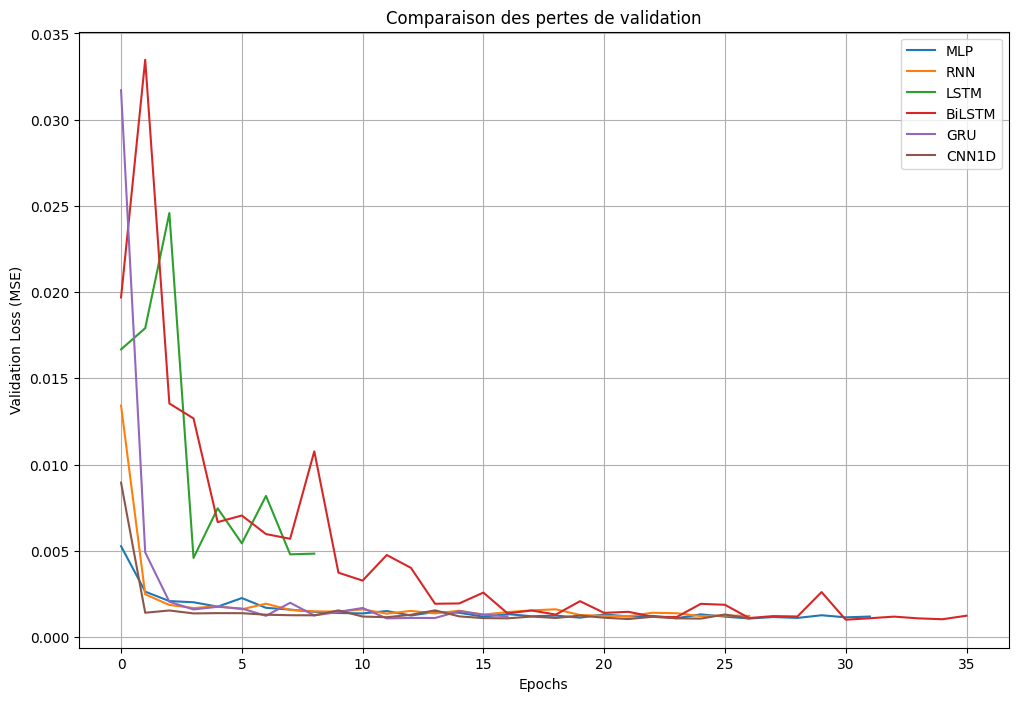

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_mlp.history['val_loss'], label='MLP')
plt.plot(history_rnn.history['val_loss'], label='RNN')
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.plot(history_bilstm.history['val_loss'], label='BiLSTM')
plt.plot(history_gru.history['val_loss'], label='GRU')
plt.plot(history_conv.history['val_loss'], label='CNN1D')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss (MSE)')
plt.title('Comparaison des pertes de validation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interactive_model_plot(y_test, y_preds_dict, horizon=6):
    def update(start=0, length=100, step_index=0):
        end = start + length
        plt.figure(figsize=(16, 10))
        for i, (model_name, y_pred) in enumerate(y_preds_dict.items(), 1):
            plt.subplot(3, 2, i)
            plt.plot(y_test[start:end, step_index], 'o-', label='Vrai', alpha=0.7)
            plt.plot(y_pred[start:end, step_index], 'x-', label=f'Prédit ({model_name})', alpha=0.7)
            plt.title(f'{model_name} - Prédiction vs Vrai (t+{step_index+1})')
            plt.xlabel("Temps")
            plt.ylabel("Valeur")
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.suptitle(f"Comparaison des modèles pour la prédiction à t+{step_index+1}", fontsize=16, y=1.02)
        plt.show()

    start_slider = widgets.IntSlider(min=0, max=len(y_test)-100, step=10, value=0, description='Start')
    length_slider = widgets.IntSlider(min=20, max=300, step=10, value=100, description='Longueur')
    step_slider = widgets.IntSlider(min=0, max=horizon-1, step=1, value=0, description='t+horizon')

    ui = widgets.VBox([start_slider, length_slider, step_slider])
    out = widgets.interactive_output(update, {
        'start': start_slider,
        'length': length_slider,
        'step_index': step_slider
    })
    display(ui, out)


In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interactive_model_plot(y_test, y_preds_dict, horizon=6):
    def update(start=0, length=100, step_index=0):
        end = start + length
        plt.figure(figsize=(16, 10))
        for i, (model_name, y_pred) in enumerate(y_preds_dict.items(), 1):
            plt.subplot(3, 2, i)
            plt.plot(y_test[start:end, step_index], 'o-', label='Vrai', alpha=0.7)
            plt.plot(y_pred[start:end, step_index], 'x-', label=f'Prédit ({model_name})', alpha=0.7)
            plt.title(f'{model_name} - Prédiction vs Vrai (t+{step_index+1})')
            plt.xlabel("Temps")
            plt.ylabel("Valeur")
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.suptitle(f"Comparaison des modèles pour la prédiction à t+{step_index+1}", fontsize=16, y=1.02)
        plt.show()

    start_slider = widgets.IntSlider(min=0, max=len(y_test)-100, step=10, value=0, description='Start')
    length_slider = widgets.IntSlider(min=20, max=300, step=10, value=100, description='Longueur')
    step_slider = widgets.IntSlider(min=0, max=horizon-1, step=1, value=0, description='t+horizon')

    ui = widgets.VBox([start_slider, length_slider, step_slider])
    out = widgets.interactive_output(update, {
        'start': start_slider,
        'length': length_slider,
        'step_index': step_slider
    })
    display(ui, out)


In [ ]:
# Exemple si horizon = 6
interactive_model_plot(y_test, {
    "MLP": y_pred_mlp,
    "RNN": y_pred_rnn,
    "LSTM": y_pred_lstm,
    "BiLSTM": y_pred_bilstm,
    "GRU": y_pred_gru,
    "CNN1D": y_pred_conv
}, horizon=6)


Output()

le meilleur model pour des architecture asser leger est
* le 1er LSTM         RMSE = 30.12    ;    R² = 0.9284
* 2 em le RNN         RMSE = 30.54    ;    R² = 0.9263
* 3 em le Bi LSTM     RMSE = 31.12    ;    R² = 0.9235

Prophet

In [ ]:
pip install prophet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3178x5qh/2ojfdgb9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3178x5qh/gv6om505.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26935', 'data', 'file=/tmp/tmp3178x5qh/2ojfdgb9.json', 'init=/tmp/tmp3178x5qh/gv6om505.json', 'output', 'file=/tmp/tmp3178x5qh/prophet_modelvc6uxyyx/prophet_model-20250414213137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Prophet
MSE  : 4059.7305
MAE  : 61.5533
MAPE : 0.0302
RMSE : 63.7160
R²   : -29.5117
------------------------------


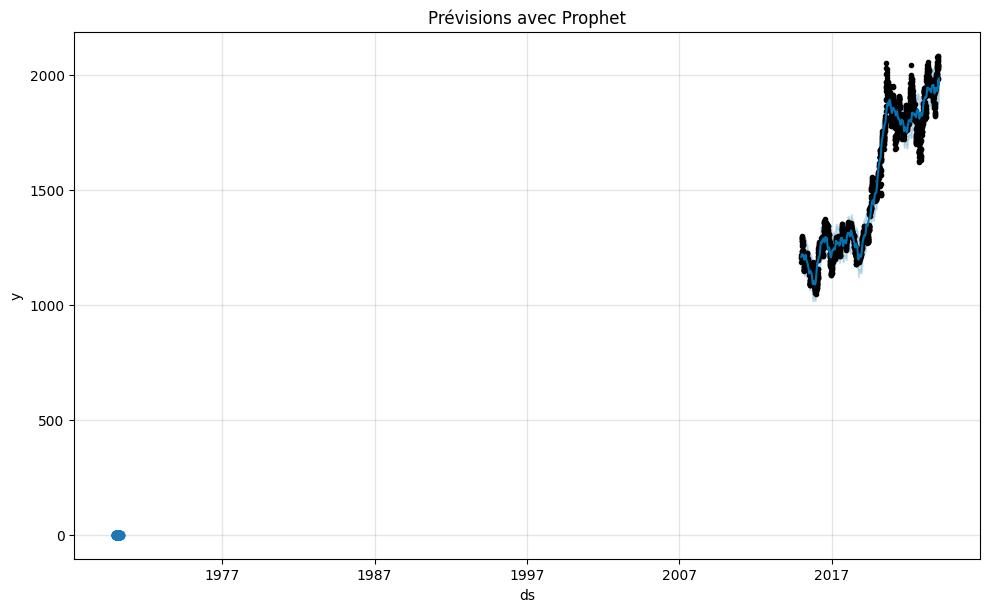

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

prophet_data = pd.read_csv("https://raw.githubusercontent.com/elm19/GoldSpot-Predictor/refs/heads/djeri/data/processed-data/price-gold.csv")
prophet_data['Date'] =  pd.to_datetime(prophet_data['Date'])
prophet_data = prophet_data.rename(columns={'Date': 'ds', 'Close': 'y'})


# entraînement = tout sauf les 6 derniers jours
train_df = prophet_data.iloc[:-6]
test_df = prophet_data.iloc[-6:]

#train
Prophet_model = Prophet()
Prophet_model.fit(train_df)

#prediction
future = Prophet_model.make_future_dataframe(periods=6)
forecast = Prophet_model.predict(future)

forecast_test = forecast[['ds', 'yhat']].tail(6)  # les 6 dernières dates
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

#metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(" Prophet")
print(f"MSE  : {mse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print("-" * 30)

start = 0
end = 100
step_index = 0
# Visualisation
Prophet_model.plot(forecast)
plt.plot(y_test[start:end, step_index], 'o-', label='Vrai', alpha=0.7)
plt.title("Prévisions avec Prophet")
plt.grid(True)
plt.show()


faison glisser Prophet jour par jour sur la série

Prophet a ete entrainer sur tout le data pour predire les 6 dernier jour .


In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
from tqdm import tqdm

def rolling_prophet_forecast(data, horizon=6, lookback=100):
    """
    Pour chaque jour à partir de lookback, on prédit les 'horizon' jours suivants avec Prophet.
    """
    data = data[['Date', 'Close']].copy()
    data.columns = ['ds', 'y']
    data['ds'] = pd.to_datetime(data['ds'])

    y_preds = []
    y_true = []

    for i in tqdm(range(lookback, len(data) - horizon)):
        train = data.iloc[i - lookback:i]
        true_values = data.iloc[i:i + horizon]['y'].values

        model = Prophet(daily_seasonality=True)
        model.fit(train)

        future = model.make_future_dataframe(periods=horizon)
        forecast = model.predict(future)

        preds = forecast[['ds', 'yhat']].tail(horizon)['yhat'].values
        y_preds.append(preds)
        y_true.append(true_values)

    return np.array(y_true), np.array(y_preds)


prophet_data = pd.read_csv("https://raw.githubusercontent.com/elm19/GoldSpot-Predictor/refs/heads/djeri/data/processed-data/price-gold.csv")
y_true_prophet, y_pred_prophet = rolling_prophet_forecast(prophet_data, horizon=6, lookback=100)


Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3178x5qh/5cba2lwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3178x5qh/822yzm6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59811', 'data', 'file=/tmp/tmp3178x5qh/5cba2lwy.json', 'init=/tmp/tmp3178x5qh/822yzm6h.json', 'output', 'file=/tmp/tmp3178x5qh/prophet_modelz7tj7bzx/prophet_model-20250414213717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:37:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:37:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
 77%|███████▋  | 1711/2210 [05:16<01:39,  5.03it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def evaluate_metrics(y_true, y_pred, model_name="Prophet"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\ {model_name}")
    print(f"MSE  : {mse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MAPE : {mape:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    print("-" * 30)

evaluate_metrics(y_true_prophet[:, 0], y_pred_prophet[:, 0], model_name="Prophet (rolling)")


In [ ]:
import matplotlib.pyplot as plt

def plot_prophet_predictions(y_true, y_pred, horizon_index=0, sample_range=(0, 100), model_name="Prophet"):
    """
    Affiche la comparaison entre vraies valeurs et prédictions de Prophet pour un pas donné.
    """
    start, end = sample_range

    plt.figure(figsize=(12, 6))
    plt.plot(y_true[start:end, horizon_index], label="Vrai", marker='o', alpha=0.7)
    plt.plot(y_pred[start:end, horizon_index], label="Prédit par Prophet", marker='x', alpha=0.7)
    plt.title(f"{model_name} – Prédiction vs Réalité (t+{horizon_index+1})")
    plt.xlabel("Index temporel")
    plt.ylabel("Valeur")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_prophet_predictions(y_true_prophet, y_pred_prophet, horizon_index=0, sample_range=(0, 100))


les resultat obtuenu avec prohet sont tres faible comparer a model de deep learning . ce echec est dut a plusieurs facteur tel que le fais que prophet est un model de deep learning Qui modélise la série temporelle comme une combinaison de :

𝑦
(
𝑡
)
=
𝑔
(
𝑡
)
+
𝑠
(
𝑡
)
+
ℎ
(
𝑡
)
+
𝜀
𝑡
y(t)=g(t)+s(t)+h(t)+ε
t
​

Où :

g(t) → tendance non-linéaire (croissance linéaire ou logistique)

s(t) → saisonnalité (hebdomadaire, annuelle…)

h(t) → effet des jours spéciaux (jours fériés, événements)

εₜ → erreur aléatoire


il ne peut donc pas prendre en compte les autre features disponible .

il ne capete pas aussi bien les relation non lineaire  et n aprend pas il ne fait que deduirt un alllure a la quel il se fie dans le temps indepenment des autre donné . il se base sur des tendance et saisonnaliter uniquement pour extrapoler chaque jour .

sauf presence news prohete pourait etre efficace en prediction sur les heurs mais pas en prediction daily

AMELiauRONT LE MODEL LSTM

In [ ]:
def create_optimized_lstm(input_shape,horizon=6):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.LSTM(32, activation='tanh'),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# LSTM
optimized_lstm_model = create_optimized_lstm(input_shape)
history_optimized_lstm, loss_optimised_lstm = train_and_evaluate_model(optimized_lstm_model, X_train, y_train, X_vald, y_vald, X_test, y_test, "LSTM")


In [ ]:
y_pred_optimized_lstm_model_lstm = optimized_lstm_model.predict(X_test)


In [ ]:
y_pred_optimized_lstm_true = scalery.inverse_transform(y_pred_optimized_lstm_model_lstm)


In [ ]:
results.append(evaluate_model_metrics(y_test_true, y_pred_optimized_lstm_true,   "LSTM optimized"))


In [ ]:
#  LSTM
# MSE  : 907.1389
# MAE  : 22.5019
# MAPE : 0.0120
# RMSE : 30.1187
# R²   : 0.9284

In [ ]:
plt.plot(history_optimized_lstm.history['val_loss'], label='LSTM')


for collab

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit


for terminal


In [ ]:
# !tensorboard --logdir=logs/fit

Prophet

In [ ]:
# y_predicted_prophet = Prophet()
# y_predicted_prophet.fit(df_prophet)
# future = y_predicted_prophet.make_future_dataframe(periods=30)
# forecast = y_predicted_prophet.predict(future)
# fig = y_predicted_prophet.plot(forecast)
# plt.show()